**Group information**

| Family name | First name | Email address |
| ----------- | ---------- | ------------- |
|Gómez Argüelles|  Gerardo  |  gerardo.gomez@bse.eu |
|  Tausendschön   |     Oliver  | oliver.tausendschoen@bse.eu  |
|             |            |               |

**Design Document**
Add your Design Document based on Lecture 1 below:



**Context**

The frequency and severity of natural disasters have been steadily increasing, with floods representing the most prevalent and fastest-growing category of events globally. In response to this trend, we aim to develop a system capable of detecting and mapping flood events in specific regions of Asia. The primary objective is to provide timely and accurate flood detection outputs based on satellite data. By leveraging Earth observation technologies, particularly radar imagery from Sentinel-1 satellites, the system will help stakeholders better understand the extent of flood events shortly after they occur. This system focuses on operational usability, enabling daily flood monitoring through a deep learning-based segmentation approach trained on the ETCI 2021 Flood Detection dataset.

**Goals**

- Develop a flood detection model that identifies flooded areas from a given date onward within a defined region in Asia. More specifically,we output flood extent by subtracting permanent water bodies. We deliberately focus on Asia, because there are gaps in real-time flood detection, unlike in countries such as the U.S. and Europe (they often have nationwide systems in place)
- Create a system that generates daily outputs based on satellite imagery, highlighting locations where flooding is occurring
- Deliver a model with high accuracy (IoU > 0.60) and balanced precision-recall metrics for reliable flood detection
- Process Sentinel-1 radar imagery (VV and VH polarizations) to enable detection regardless of cloud cover or time of day
- Provide outputs that distinguish between permanent water bodies and flood waters

**Non-Goals**

- The system will not predict when or why a flood will occur
- The system will not estimate the damage or impact on infrastructure or populations
- The system will not perform long-term forecasting or risk modeling
- The system will not incorporate non-satellite data sources (e.g., ground sensors, crowd-sourced data)
- The system will not integrate with emergency alert systems or automated response mechanisms

**Assumptions**

- We have access to the European Space Agency Data where we can obtain 10-meter resolution Sentinel-1 radar data for our areas of interest
- With 10×10 meter pixels, we can detect floods at a scale sufficient for regional and country-level disaster response
- High-resolution satellite images require tiling into manageable 256×256 pixel segments for efficient processing
- We have access to a training dataset (ETCI 2021) containing Sentinel-1 images with corresponding flood masks (0 for non-flood and 1 for flood areas)
- We have access to permanent water body data both during training and inference phases
- Users require daily updates starting from the flood onset and need offline-compatible outputs for areas with potentially compromised infrastructure
- Class imbalance in flood detection (approximately 5% flood pixels vs. 95% background pixels) must be addressed in the model design
- Sentinel-1 radar data provides more reliable flood detection than optical imagery due to its ability to penetrate clouds

**Requirements**

*Technical Requirements*

- Data Processing Pipeline: The system must process Sentinel-1 SAR imagery (both VV and VH polarizations) and convert them into an appropriate format for model input. Owner: Data Engineering Team
- Model Architecture: Implement a UNet architecture with ResNet34 encoder for semantic segmentation of flood areas. Owner: Machine Learning Team
- Tiling System: Process large satellite images by dividing them into 256×256 pixel tiles. Owner: Data Engineering Team
- Daily Update Capability: The system must be able to ingest and process new satellite data as it becomes available (typically daily or near-daily). Owner: Developing Team
- Performance Metrics: The system must track IoU, Precision, Recall, and F1 score to evaluate model performance. Owner: ML Monitoring Team

*User Requirements*

- Daily Flood Output Availability: The user must receive updated flood maps on a daily basis starting from the onset of a flood event. Owner: Deployment/Operations Team
- Custom Area Selection: The user must be able to define the Area of Interest (AOI) for which flood detection will be performed. Owner: UI/UX Team
- Offline Data Accessibility: The system must deliver outputs in a format that can be accessed without a stable internet connection, supporting generator-powered environments. Owner: Deployment/Field Support Team
- Water vs. Flood Distinction: The system must differentiate between permanent water bodies and flood waters in the output. Owner: ML Team

**Measure of Success**

The success of the flood detection system will be measured by:

*Model Performance:*

- IoU (Intersection over Union) > 0.60 on the validation set
- F1 score > 0.75 on the validation set
- Balanced precision and recall metrics (both > 0.65)


*System Performance:*

- Processing time < 2 hours for daily satellite data coverage of a typical disaster area (100,000 km²)
- Availability of results within 6 hours of new satellite data acquisition


*User-Centric Metrics:*

- Successful deployment in at least 3 flood events during the first year of operation
- Positive feedback from disaster response teams regarding accuracy and usefulness of flood maps
- Reduction in time required to assess flood extent compared to manual methods

**Risk**

*Technical Risks*

- Data Availability: Sentinel-1 revisit times may not always provide daily coverage for all regions. 
- False Positives: Urban areas with radar shadows can be misclassified as water. 
- Model Generalization: The model may not perform well in geographic regions with different characteristics than those in the training data. 
- Processing Delays: High demand during major disasters may cause processing backlogs. - 

*Operational Risks*

- Internet Connectivity: Users in disaster areas may have limited connectivity. 
- User Training: End users may require training to properly interpret flood maps. 
- Validation Data: Limited ground truth data for validating model outputs. M



# Assignment_03_model_training_solution

Make sure to use a GPU and have access to internet connection in the Kaggle notebook:

1.  On the arrow on the bottom right, select "Notebook Options" and then "Accelerator" to choose the GPU P100, and select "Variables & Files" under Persistence. **Note that Kaggle allows 30h per week per user of accelerated computing. Plan your work accordingly. It takes time to load the data and you may experience unavailability of GPUs or Session Errors.**
1. Make sure your Kaggle account is phone verified by clicking "Get phone verified" in the left sidebar under "Notebook options" and following the steps (this step is required to switch on the internet connection needed to install packages). 
1. After phone verification, the full settings menu should be visible. Toggle the "Internet" switch.

More visualizations of the process to connect the notebook to the internet are provided [here](https://stackoverflow.com/questions/68142524/cannot-access-internet-on-kaggle-notebook)


## Requirements:

1. Downloading the tiles of the ecti2021 here: [ecti2021.zip](https://www.dropbox.com/scl/fi/tuvroadxyummourvx6cmz/ecti2021.zip?rlkey=wsc19sue84ytkphheptq28ica&st=9p8npaly&dl=0)
1. Go to the "Side Bar", Click on "Input"
1. Upload as `ecti2021` the file: `ecti2021.zip`  which contains the following four files: `train.zip`, `val_without_ref_labels.zip` , and the `water_tiles.csv` and `background_tiles.csv` from the `data_preparation.ipynb` notebook. 

# Step 0: Enviroment setting

In [2]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albu/albumentations --no-cache-di

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:000:00:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing 

In [3]:
# load packages
import os
import sys
import cv2
import numpy as np
import pandas as pd
from glob import glob
import torch.nn as nn
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
# Set up plotting options
%matplotlib inline
import pickle
from pickle import load
import torch
from torch.utils.data import Dataset, DataLoader

# Step 1: Load the dataset files

In [4]:
# Set path to where dataset is downloaded
dataset_root = '/kaggle/input/d/gerardogmezargelles/ecti2021/ecti2021' #set accordingly based on how you uploaded the data
#dataset_root = 'ecti2021/ecti2021' #set accordingly based on how you uploaded the data
# get number of training/validation regions
#train_dir = os.path.join(dataset_root, 'train')
train_dir = os.path.join(dataset_root, 'train', 'train')

test_dir = os.path.join(dataset_root, 'val_without_ref_labels/val')

n_train_regions = len(glob(train_dir+'/*/'))
n_test_regions = len(glob(test_dir+'/*/'))

# NOTE: make sure number of regions is NOT 0, otherwise it might be that the code is not able to read the data. 
print('Number of training temporal-regions: {}'.format(n_train_regions))
print('Number of test temporal-regions: {}'.format(n_test_regions))


Number of training temporal-regions: 31
Number of test temporal-regions: 10


From the Lab_01_data_preparation, we identified that the ETCI 2021 Competition on Flood Detection is composed of 33'405 tiles. However, we also identified tiles that have empty VV/VH but have a non-zero label. We already excluded these tiles when saving the `water_tiles.csv` and `background_tiles.csv`. The dataset used in this notebook should contain 27'214 tiles. 

## Utils functions

In [5]:
def visualize(df_row, figsize=[25, 15]):
    # get image paths
    vv_image_path = df_row['vv_image_path']
    vh_image_path = df_row['vh_image_path']
    flood_label_path = df_row['flood_label_path']
    water_body_label_path = df_row['water_body_label_path']

    # create RGB image from S1 images
    rgb_name = get_filename(vv_image_path)
    vv_image = cv2.imread(vv_image_path, 0) / 255.0
    vh_image = cv2.imread(vh_image_path, 0) / 255.0
    rgb_image = s1_to_rgb(vv_image, vh_image)

    # get water body label mask
    water_body_label_image = cv2.imread(water_body_label_path, 0) / 255.0

    # plot images
    plt.figure(figsize=tuple(figsize))
    if df_row.isnull().sum() > 0:
        # plot RGB S1 image
        plt.subplot(1,2,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot water body mask
        plt.subplot(1,2,2)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')
    else:
        flood_label_image = cv2.imread(flood_label_path, 0) / 255.0
        # plot RGB S1 image
        plt.subplot(1,3,1)
        plt.imshow(rgb_image)
        plt.title(rgb_name)

        # plot flood label mask
        plt.subplot(1,3,2)
        plt.imshow(flood_label_image)
        plt.title('Flood mask')

        # plot water body mask
        plt.subplot(1,3,3)
        plt.imshow(water_body_label_image)
        plt.title('Water body mask')

def s1_to_rgb(vv_image, vh_image):
    eps=1e-06
    ratio_image = np.clip(np.nan_to_num(vv_image/(vh_image+eps), 0), 0, 1) # outside [0,1] will be clipped
    rgb_image = np.stack((vv_image, vh_image, ratio_image), axis=2) #different from lab01: np.abs(red) / np.abs(green) 
    return rgb_image

def visualize_result(df_row, prediction, figsize=[25, 15]):
    vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
    vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
    rgb_input = s1_to_rgb(vv_image, vh_image)

    plt.figure(figsize=tuple(figsize))
    plt.subplot(1,2,1)
    plt.imshow(rgb_input)
    plt.title('RGB w/ result')
    plt.subplot(1,2,2)
    plt.imshow(prediction)
    plt.title('Result')

# Step 2: Create training dataframes

In [6]:
def get_filename(filepath,split_symbol='/'):
    return filepath.split(split_symbol)[-1]

def read_csv(csvpath,split_symbol='\\'):
    path_list = np.loadtxt(csvpath,delimiter=" ", dtype=str).tolist()
    return [get_filename(pth,split_symbol) for pth in path_list]

In [7]:
#water_image_names = read_csv('ecti2021/ecti2021/water_tiles.csv') #from lab01 make sure the path is correct
#background_image_names = read_csv('ecti2021/ecti2021/background_tiles.csv')

water_image_names = read_csv('/kaggle/input/d/gerardogmezargelles/ecti2021/ecti2021/background_tiles.csv') #from lab01 make sure the path is correct
background_image_names = read_csv('/kaggle/input/d/gerardogmezargelles/ecti2021/ecti2021/water_tiles.csv')

region_name_dates0 = ['_'.join(n.split('_')[:2]) for n in water_image_names]
region_name_dates1 = ['_'.join(n.split('_')[:2]) for n in background_image_names]

vv_image_paths, vh_image_paths, flood_label_paths, water_body_label_paths = [], [], [], []


water_image_paths,background_image_paths = [],[]

for i in range(len(water_image_names)):
    vv_image_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'vv', water_image_names[i])
    vv_image_paths.append(vv_image_path)
    water_image_paths.append(vv_image_path)
    
    # get vh image path
    vh_image_name = water_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = water_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = water_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates0[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)
    
for i in range(len(background_image_names)):
    vv_image_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'vv', background_image_names[i])
    vv_image_paths.append(vv_image_path)
    background_image_paths.append(vv_image_path)
    
    # get vh image path
    vh_image_name = background_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path
    flood_image_name = background_image_names[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths.append(flood_label_path)

    # get water body mask path
    water_body_label_name = background_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates1[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)
    

In [8]:
#Shuffle the index and then split in train and validation
n=len(vv_image_paths) #number of images in the dataset
arr = np.arange(n) #array 0...n-1
np.random.shuffle(arr) # shuffle it
train_idx=arr[0:int(np.round(0.80*n))] #80% train
valid_idx=arr[int(np.round(0.80*n)):] #20% validation
print("Number of tiles in training set:",train_idx.size)
print("Number of tiles in validation set:",valid_idx.size)
print("Number of tiles in the training and validation set:",train_idx.size+valid_idx.size) 

Number of tiles in training set: 21771
Number of tiles in validation set: 5443
Number of tiles in the training and validation set: 27214


In [9]:
vv_image_paths_train = list(np.array(vv_image_paths)[train_idx])
vh_image_paths_train = list(np.array(vh_image_paths)[train_idx])
flood_label_paths_train = list(np.array(flood_label_paths)[train_idx])
water_body_label_paths_train = list(np.array(water_body_label_paths)[train_idx])

train_paths = {'vv_image_path': vv_image_paths_train,
        'vh_image_path': vh_image_paths_train,
        'flood_label_path': flood_label_paths_train,
        'water_body_label_path': water_body_label_paths_train,
}

train_df = pd.DataFrame(train_paths)

print(train_df.shape)
train_df.head()

(21771, 4)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path
0,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
1,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
2,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
3,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
4,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...


In [10]:
vv_image_paths_valid = list(np.array(vv_image_paths)[valid_idx])
vh_image_paths_valid = list(np.array(vh_image_paths)[valid_idx])
flood_label_paths_valid = list(np.array(flood_label_paths)[valid_idx])
water_body_label_paths_valid = list(np.array(water_body_label_paths)[valid_idx])

valid_paths = {'vv_image_path': vv_image_paths_valid,
        'vh_image_path': vh_image_paths_valid,
        'flood_label_path': flood_label_paths_valid,
        'water_body_label_path': water_body_label_paths_valid,
}


valid_df = pd.DataFrame(valid_paths)

print(valid_df.shape)
valid_df.head()

(5443, 4)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path
0,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
1,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
2,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
3,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
4,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...


## # Step 2b: Create training undersampled dataframes

In [11]:
background_image_paths_train = [path for path in background_image_paths if path in vv_image_paths_train]
background_num_train = len(background_image_paths_train)
print('Number of background tiles included in training:',background_num_train)

water_image_paths_train = [path for path in water_image_paths if path in vv_image_paths_train]
water_image_names_train = [get_filename(pth) for pth in water_image_paths_train]
region_name_dates2 = ['_'.join(n.split('_')[:2]) for n in water_image_names_train]
water_num_train = len(water_image_paths_train)
print('Number of water tiles included in training:',water_num_train)

Number of background tiles included in training: 8361
Number of water tiles included in training: 13410


In [12]:
num_samples = int(water_num_train * 0.15) #include 15% of water tiles
arr = np.arange(int(water_num_train * 0.15))  # array 0...n-1
np.random.shuffle(arr)  # shuffle it
background_image_paths_train_undersampled = list(np.array(background_image_paths_train)[arr[0:num_samples]])
background_image_names_train_undersampled = [get_filename(pth) for pth in background_image_paths_train_undersampled]
print('Number of background tiles included in training after undersampling:',len(background_image_names_train_undersampled))
region_name_dates3 = ['_'.join(n.split('_')[:2]) for n in background_image_names_train_undersampled]

vh_image_paths_train_undersampled, flood_label_paths_train_undersampled, water_body_label_paths_train_undersampled = [], [], []
for i in range(len(water_image_names_train)):
    # get vh image path
    vh_image_name = water_image_names_train[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths_train_undersampled.append(vh_image_path)

    # get flood mask path
    flood_image_name = water_image_names_train[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths_train_undersampled.append(flood_label_path)

    # get water body mask path
    water_body_label_name = water_image_names_train[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates2[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths_train_undersampled.append(water_body_label_path)

vv_image_paths_train_undersampled = water_image_paths_train
print('Number of water body label included in training after undersampling:',len(water_body_label_paths_train_undersampled))
for i in range(len(background_image_names_train_undersampled)):
    vv_image_paths_train_undersampled.append(background_image_paths_train_undersampled[i])
    
    # get vh image path
    vh_image_name = background_image_names_train_undersampled[i].replace('vv', 'vh')
    vh_image_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths_train_undersampled.append(vh_image_path)

    # get flood mask path
    flood_image_name = background_image_names_train_undersampled[i].replace('_vv', '')
    flood_label_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'flood_label', flood_image_name)
    flood_label_paths_train_undersampled.append(flood_label_path)

    # get water body mask path
    water_body_label_name = background_image_names_train_undersampled[i].replace('_vv', '')
    water_body_label_path = os.path.join(train_dir, region_name_dates3[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths_train_undersampled.append(water_body_label_path)
assert len(vv_image_paths_train_undersampled)==len(vh_image_paths_train_undersampled)==len(flood_label_paths_train_undersampled)==len(water_body_label_paths_train_undersampled)
print('Number of overall images  included in training after undersampling:',len(water_body_label_paths_train_undersampled))

Number of background tiles included in training after undersampling: 2011
Number of water body label included in training after undersampling: 13410
Number of overall images  included in training after undersampling: 15421


**1) Based on the consideration done in Lab1 and the above calculation, explain the original dataset is in term of class imbalance and how this changed in the undersample dataset.**



As we have seen in the data preparation done in Lab1, the original dataset seems to be imbalanced. This means, there are too many backgound-only tiles relatively to the other classes.

Overall, we have two classes:

- **Water Tiles**: Tiles where at least one pixel is labeled as flooded
- **Background Tiles**: Tiles where no flooding is present

After cleaning the dataset (removing the blank images and blank labels), this ratio is about **38% for Water tiles** and  **62% Background**. (8335 Water tiles and 13 435 Background Tiles)

However, we when training our model and we have such an imbalance, it will be biased towards predicting the overly balanced class. Do in our case, the model could end up learning to always predict background since it's more frequent. This implies:

- High Accucary but poor performance on minorit class (lot's of wrong positives)
- Low Intersection over Union. This is the evaluation metric and we want to maximize it!

This is particularly dangerous in flood detectin because missing flooded areas can have costly consequences in real life!

To adress this imbalance, we **apply undersampling**, keeping all water tiles but **randomly sampling only 15% of the background tiles**. This results into a new class distribution:

- 87% Water Tiles
- 13% Background Tiles

This ensures that the model sees flood examples more frequently and avoids the model to just always predict non-flooded.

In [13]:
train_paths_undersample = {'vv_image_path': vv_image_paths_train_undersampled,
        'vh_image_path': vh_image_paths_train_undersampled,
        'flood_label_path': flood_label_paths_train_undersampled,
        'water_body_label_path': water_body_label_paths_train_undersampled
}
train_df_undersample = pd.DataFrame(train_paths_undersample)

print(train_df_undersample.shape)
train_df_undersample.head() 

(15421, 4)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path
0,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
1,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
2,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
3,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
4,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...


# Step 3: Visualize images

This section is meant to be used to experiment the data. Feel free to change things and to explore the data.

In [14]:
train_df

,vv_image_path,vh_image_path,flood_label_path,water_body_label_path
0,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
1,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
2,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
3,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
4,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
...,...,...,...,...
21766,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
21767,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
21768,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
21769,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...


In [15]:
import os
print(os.getcwd())


/kaggle/working


In [16]:
cv2.imread(train_df_undersample.iloc[1200]['vv_image_path'],0)

array([[197, 189, 189, ..., 181, 185, 176],
       [192, 174, 181, ..., 164, 164, 161],
       [171, 152, 154, ..., 170, 159, 160],
       ...,
       [179, 175, 166, ..., 167, 177, 176],
       [173, 168, 161, ..., 187, 186, 186],
       [170, 163, 159, ..., 186, 182, 179]], dtype=uint8)

In [17]:
train_df_undersample.iloc[3600]['vv_image_path']

'/kaggle/input/d/gerardogmezargelles/ecti2021/ecti2021/train/train/nebraska_20170309t002110/tiles/vv/nebraska_20170309t002110_x-10_y-27_vv.png'

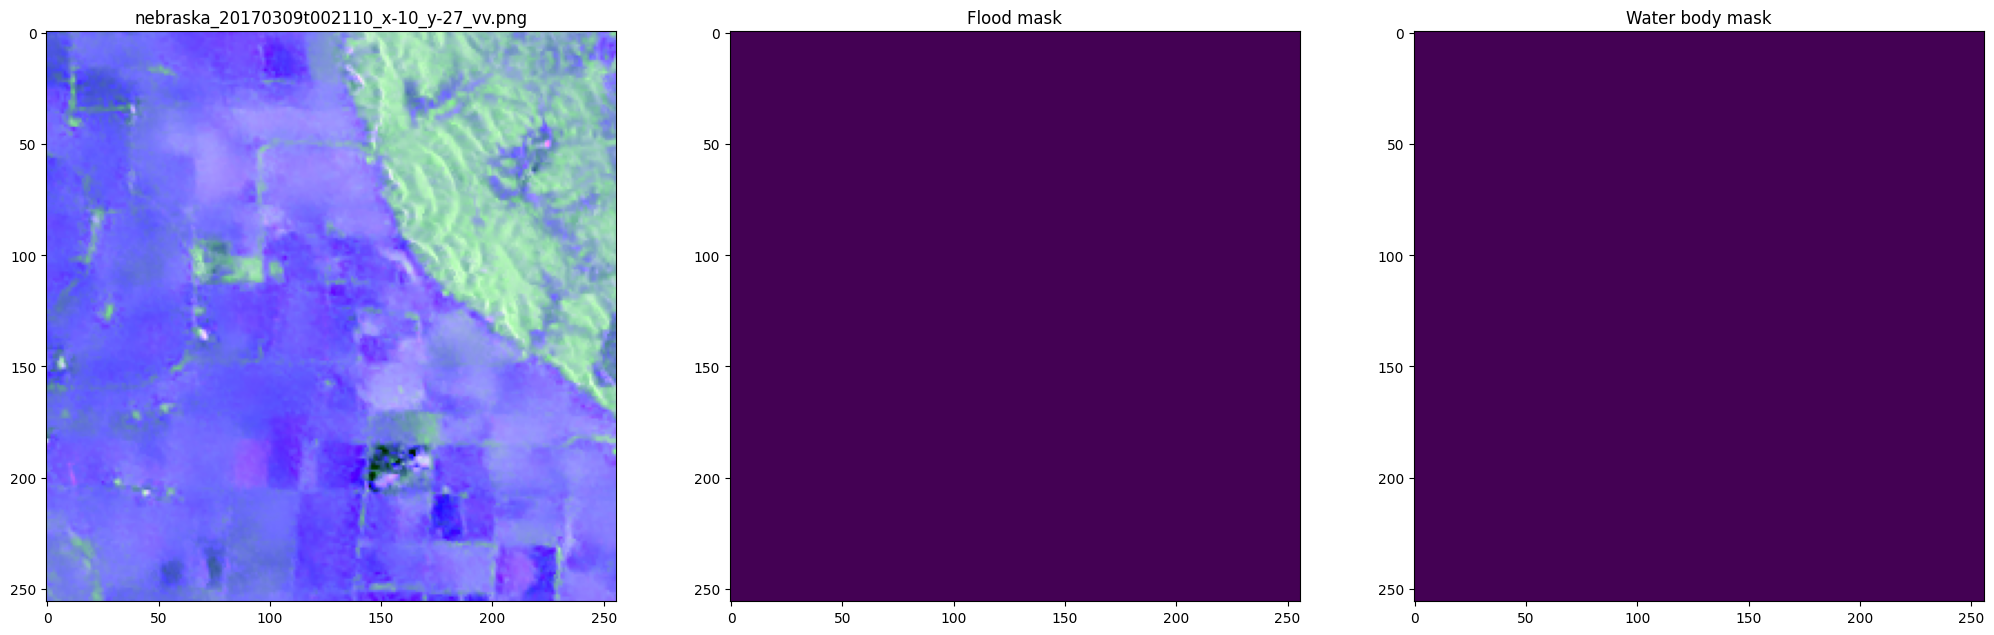

In [18]:
visualize(train_df_undersample.iloc[3600])

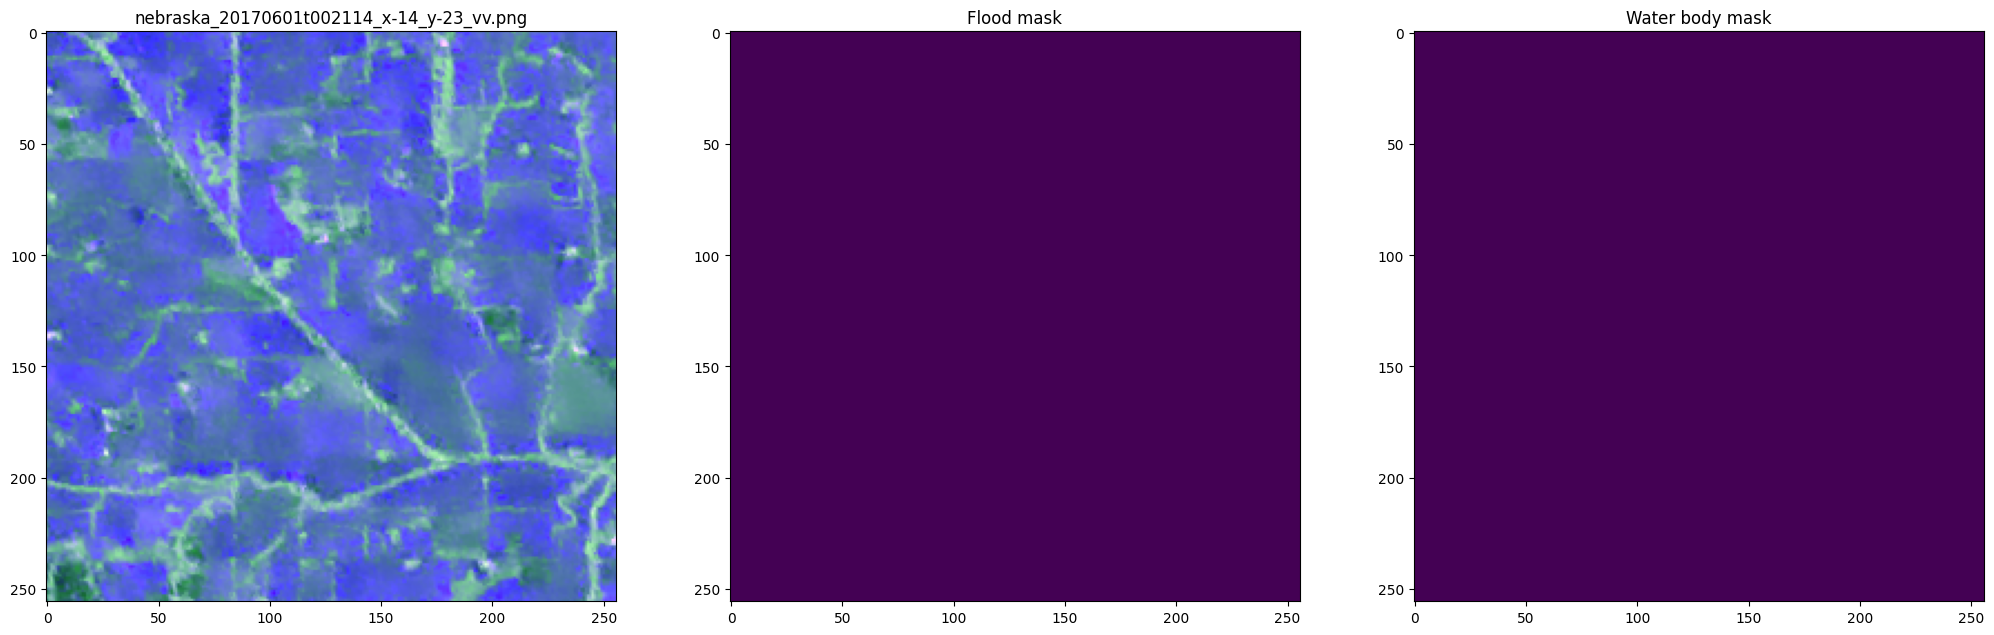

In [19]:
visualize(train_df.iloc[3677])

# Step 4: Setup the dataset for machine learning

Since the Phase 1 (Development phase) of the ETCI 2021 Competition on Flood Detection provided with training data (which includes reference data) and a validation data (without reference data until phase 1 concludes),we will split our training dataset (that contains flood masks) into a smaller training and development set. 


### Create a PyTorch dataset

We will be using the PyTorch deep learning library to format this dataset and create our machine learning model. Therefore we will need to create a custom Dataset class and pass it into a DataLoader object (see the [PyTorch Dataset Tutorial](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html)  for more detail on the topic). To compute image transformations we will use the [Albumentations](https://github.com/albumentations-team/albumentations) package. 

In [20]:
class ETCIDataset(Dataset):
    def __init__(self, dataframe, split, transform=None):
        self.split = split
        self.dataset = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataset.shape[0]


    def __getitem__(self, index):
        example = {}
        
        df_row = self.dataset.iloc[index]

        # load vv and vh images
        vv_image = cv2.imread(df_row['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(df_row['vh_image_path'], 0) / 255.0
        
        # convert vv and vh images to rgb
        rgb_image = s1_to_rgb(vv_image, vh_image)

        if self.split == 'test':
            # no flood mask should be available
            example['image'] = rgb_image.transpose((2,0,1)).astype('float32')  #HWC->CHW
        else:
            # load ground truth flood mask
            flood_mask = cv2.imread(df_row['flood_label_path'], 0) / 255.0

            # compute transformations
            
            if self.transform:
                augmented = self.transform(image=rgb_image, mask=flood_mask)
                rgb_image = augmented['image']
                flood_mask = augmented['mask']

            example['image'] = rgb_image.transpose((2,0,1)).astype('float32') #HWC->CHW
            example['mask'] = flood_mask.astype('int64')
            #example['mask'] = np.expand_dims(flood_mask.astype('float32'), axis=0)

        return example


**2) Check the [Albumentations](https://github.com/albumentations-team/albumentations) package and implement both Vertical and Horizontal flip with probability 0.5 and RandomResizedCrop of 256 on both dimentions. Then load the train and validation set.**

In [21]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.RandomResizedCrop(size=[256, 256], scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0) #parameters are set to 0.8 and 1.0 to avoid too much cropping
])
train_dataset = ETCIDataset(train_df, split='train', transform=transform)
valid_dataset = ETCIDataset(valid_df, split='valid', transform=None) #APPLY TRNSFORM HERE AS WELL?
print('Trainining set size:',len(train_dataset))
print('Validation set size:',len(valid_dataset))

Trainining set size: 21771
Validation set size: 5443


In [22]:
batch_size = 100
#batch_size = 200
#batch_size = 24


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

In [23]:
train_undersampled_dataset = ETCIDataset(train_df_undersample, split='train', transform=transform)
train_undersampled_loader = DataLoader(train_undersampled_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
print('Undersampled Trainining set size:',len(train_undersampled_dataset))

Undersampled Trainining set size: 15421


# Step 5: Deep learning model creation

### Select hardware to train model

In [24]:
# check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


**3) Read carefully the documentation of the segmentation model from the [Segmentation Models](https://github.com/qubvel/segmentation_models.pytorch) package ([documentation here](https://smp.readthedocs.io/en/latest/)),  implement a UNet with resnet34 as encoder, without any pre-trained weights, and the appropriate number of in_channel and classes based on the dataset.**

In [25]:
def create_model():
  ###CODE HERE
  # create model
  model = smp.Unet(
      encoder_name="resnet34", 
      encoder_weights= None,
      #encoder_weights="imagenet", 
      in_channels=3, #VV, VH, ratio
      classes=2,#2 for cross entropy, 1 for binary cross entropy 
  )
  # move model to device
  model.to(device)
  return model


In [26]:
model_1 = create_model()              

model_1.to(device)                  

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

### Metric tracker

In [27]:
from sklearn.metrics import confusion_matrix

class EvalTracker:
    def __init__(self, n_classes=2, smooth=0.0001):
        self.n_classes = n_classes
        self.reset()
        self.smooth = smooth

    def reset(self):
        self.cm = np.zeros((self.n_classes, self.n_classes))
        self.count = 0
    
    def update(self, pred, target):
        # pred: [B, 2, H, W]
        # target: [B, H, W]
        self.count += pred.shape[0]

        # reshape inputs
        pred = pred.argmax(dim=1).flatten()  # [B*H*W]
        target = target.flatten()  # [B*H*W]

        # put into cpu memory
        pred = pred.detach().cpu().numpy()
        target = target.detach().cpu().numpy()

        # compute confusion matrix values
        self.cm += confusion_matrix(target, pred)

    def get_mean(self):
        tn, fp, fn, tp = self.cm.ravel()

        # compute IoU
        iou = tp / (tp + fp + fn + self.smooth)
        prec = tp / (tp + fp + self.smooth)
        rec = tp / (tp + fn + self.smooth)
        f1 = 2.0*prec*rec/(prec+rec)

        return iou, prec, rec, f1


# Step 6: Train model on the full dataset

### Model config, optimizer and loss function

In [28]:
# set the number of times you want the model to see all of the training data
epochs = 10
learning_rate = 1e-4
optimizer = torch.optim.Adam(model_1.parameters(), lr=learning_rate)
criteria_no_weights = nn.CrossEntropyLoss(weight=None)
#criteria_no_weights = nn.BCEWithLogitsLoss()


### Training loop

In [31]:
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_loader)
    train_loss = 0.0
    model_1.train()
    eval_logger = EvalTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        #mask = batch['mask'].to(device).unsqueeze(1).float() #ADDED A DIMENSION TO AVOID CUDA CRASH, ALSO CONVERTED TO FLOAT
        mask = batch['mask'].to(device)
        # pass images into model
        pred = model_1(image)

        # get loss
        loss = criteria_no_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
               
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_loader.dataset)
    train_loss_dict[epoch] = train_loss
        
    # valid set
    pbar = tqdm(valid_loader)
    model_1.eval()
    eval_logger = EvalTracker()
    val_loss = 0.0
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            #mask = batch['mask'].to(device).unsqueeze(1).float() #ADDED A DIMENSION TO AVOID CUDA CRASH, ALSO CONVERTED TO FLOAT
            mask = batch['mask'].to(device)
            # pass images into model
            pred = model_1(image)

            # get loss
            loss = criteria_no_weights(pred, mask)
                       
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
    
# Save the training loss values
with open('./train_loss_1_BCE.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open('./val_loss_1_BCE.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)            
# save model
torch.save(model_1.state_dict(), 'model_1_BCE.pt')

Epoch: [1/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [2/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [3/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [4/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [5/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [6/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [7/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [8/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [9/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [10/10]


  0%|          | 0/218 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

### Plot Losses

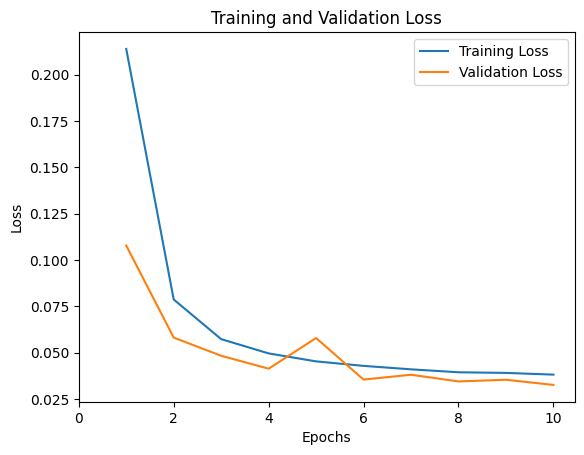

In [33]:
# Load the training and validation loss dictionaries
train_loss = load(open('/kaggle/working/train_loss_1_BCE.pkl', 'rb'))
val_loss = load(open('/kaggle/working/val_loss_1_BCE.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

# Step 7: Train model on the undersampled dataset

### Model config, optimizer and loss function

In [28]:
model_2 = create_model()
model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)
criteria_no_weights = nn.CrossEntropyLoss(weight=None)

**4) Implement a training loop similar to the one above but for the undersampled dataset. Use model_2 to avoid any overwriting of the previous model. Save the model as 'model_2d_BCE.pt'***

### Training loop

In [67]:
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_undersampled_loader)
    train_loss = 0.0
    model_2.train()
    eval_logger = EvalTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        #mask = batch['mask'].to(device).unsqueeze(1).float() #ADDED A DIMENSION TO AVOID CUDA CRASH, ALSO CONVERTED TO FLOAT
        mask = batch['mask'].to(device)
        # pass images into model
        pred = model_2(image)

        # get loss
        loss = criteria_no_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
               
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_undersampled_loader.dataset)
    train_loss_dict[epoch] = train_loss
        
    # valid set
    pbar = tqdm(valid_loader)
    model_2.eval()
    eval_logger = EvalTracker()
    val_loss = 0.0
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            #mask = batch['mask'].to(device).unsqueeze(1).float() #ADDED A DIMENSION TO AVOID CUDA CRASH, ALSO CONVERTED TO FLOAT
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model_2(image)

            # get loss
            loss = criteria_no_weights(pred, mask)
                       
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
    
# Save the training loss values
with open('./train_loss_2d_BCE.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open('./val_loss_2d_BCE.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)            
# save model
torch.save(model_2.state_dict(), 'model_2d_BCE.pt')

Epoch: [1/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [2/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [3/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [4/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [5/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [6/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [7/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [8/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [9/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [10/10]


  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

In [68]:
train_path =r'train_df.csv'
valid_path = r'valid_df.csv'
train_under_path = r'train_df_undersample.csv'
train_df.to_csv(train_path)
valid_df.to_csv(valid_path)
train_df_undersample.to_csv(train_under_path)

### Plot Losses

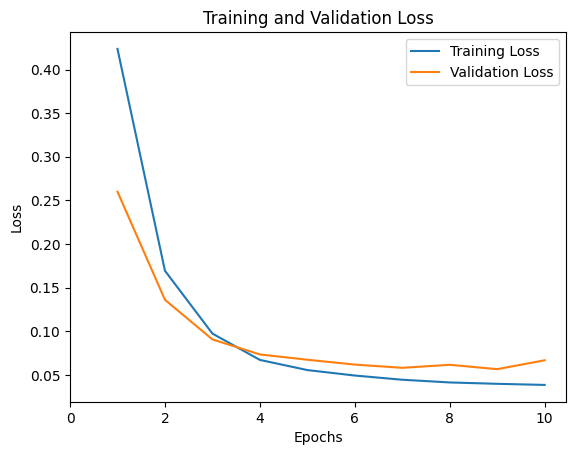

In [69]:
# Load the training and validation loss dictionaries
train_loss = load(open('/kaggle/working/train_loss_2d_BCE.pkl', 'rb'))
val_loss = load(open('/kaggle/working/val_loss_2d_BCE.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

# Step 8: Train model on the undersampled dataset with a weighted loss function

### Defining the split for the weighted Cross Entropy Loss

In [29]:
#It take quite a long time to calcualte, the ratio is around 5% flooded pixels, 95% background
n_size = len(flood_label_paths_train_undersampled)
n_flooded = np.ndarray((n_size,),)

for i in tqdm(range(n_size)):
    flood_label=cv2.imread(flood_label_paths_train_undersampled[i], 0)
    n_flooded[i] = np.sum(flood_label)/255

n_flooded_ratio = np.divide(n_flooded,256*256)
flooded_pixels = np.sum(n_flooded)
background_pixels = 256*256*n_size-np.sum(n_flooded)
print("Flooded Pixels:", flooded_pixels)
print("Background Pixels:", background_pixels)
print("Ratio:", np.mean(n_flooded_ratio))

  0%|          | 0/15382 [00:00<?, ?it/s]

Flooded Pixels: 11684804.0
Background Pixels: 996389948.0
Ratio: 0.011591207871060737


### Model config, optimizer and loss function

**5) Define the "Model config, optimizer and loss function" section as previously done but for "model_3" which will be trained with a [Weighted Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Remember to store the weights as a torch tensor, to load it in the GPU, and be careful on the order of your weights.**

In [31]:
# CODE HERE.... ANSWER:

# Create model_3
model_3 = create_model()
model_3.to(device)

# Calculate weights based on the class distribution
background_weight = flooded_pixels / (flooded_pixels + background_pixels)
flood_weight = background_pixels / (flooded_pixels + background_pixels)

# Create tensor with weights
weights = torch.tensor([background_weight, flood_weight], dtype=torch.float32, device=device)

# Define optimizer
optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

# Loss function
criteria_weights = nn.CrossEntropyLoss(weight=weights)

**6) Why did you choose the weights you used for the CrossEntropyLoss?**


We implemented an inverse frequency weighting approach for our CrossEntropyLoss function to directly address the significant class imbalance in our flood detection dataset. With approximately 5% flood pixels and 95% background pixels, our model would naturally be biased toward the majority class without intervention. By setting weights inversely proportional to class frequencies (0.05 for background and 0.95 for flood), we ensured that misclassifying a flood pixel would incur substantially more loss than misclassifying a background pixel, effectively guiding the model to pay special attention to the minority class.

This weighting strategy complements our undersampling approach by addressing imbalance at the pixel level rather than just the tile level. We chose inverse frequency weighting over alternatives like square root or logarithmic scaling because it most directly addresses our specific dataset imbalance and aligns with our primary objective of maximizing flood detection accuracy. In disaster monitoring applications like ours, the cost of missing a flood event is significantly higher than the cost of a false alarm, making this weighted approach particularly valuable for real-world implementation.

### Training Loop

In [32]:
train_loss_dict={}
val_loss_dict={}
for epoch in range(epochs):
    print('Epoch: [{}/{}]'.format(epoch+1, epochs))

    # train set
    pbar = tqdm(train_undersampled_loader)
    train_loss = 0.0
    model_3.train()
    eval_logger = EvalTracker()
    for batch in pbar:
        # load image and mask into device memory
        image = batch['image'].to(device)
        mask = batch['mask'].to(device)

        # pass images into model
        pred = model_3(image)

        # get loss
        loss = criteria_weights(pred, mask)

        # update the model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # compute and display progress
        eval_logger.update(pred, mask)
        mIoU, Prec, Rec, f1 = eval_logger.get_mean()
        pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
        train_loss += loss.item() * image.size(0)
    # calculate the average loss for both training and validation
    train_loss /= len(train_loader.dataset)
    train_loss_dict[epoch] = train_loss
    # valid set
    pbar = tqdm(valid_loader)
    val_loss = 0.0
    model_3.eval()
    eval_logger = EvalTracker()
    with torch.no_grad():
        for batch in pbar:
            # load image and mask into device memory
            image = batch['image'].to(device)
            mask = batch['mask'].to(device)

            # pass images into model
            pred = model_3(image)

            # get loss
            loss = criteria_weights(pred, mask)
            
            # compute and display progress
            eval_logger.update(pred, mask)
            mIoU, Prec, Rec, f1 = eval_logger.get_mean()
            pbar.set_description('Loss: {0:1.4f} | mIoU {1:1.4f} | Prec {2:1.4f} | Rec {3:1.4f}  | F1 score {4:1.4f}'.format(loss.item(), mIoU, Prec, Rec, f1))
            val_loss += loss.item() * image.size(0)
    val_loss /= len(valid_loader.dataset)
    val_loss_dict[epoch] = val_loss
# Save the training loss values
with open('./train_loss_2d_WBCE.pkl', 'wb') as file:
    pickle.dump(train_loss_dict, file)
     
# Save the validation loss values
with open('./val_loss_2d_WBCE.pkl', 'wb') as file:
    pickle.dump(val_loss_dict, file)   
# save model
torch.save(model_3.state_dict(), 'model_2d_WBCE.pt')

Epoch: [1/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [2/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [3/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [4/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [5/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [6/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [7/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [8/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [9/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

Epoch: [10/10]


  0%|          | 0/154 [00:00<?, ?it/s]

  0%|          | 0/55 [00:00<?, ?it/s]

### Plot Losses

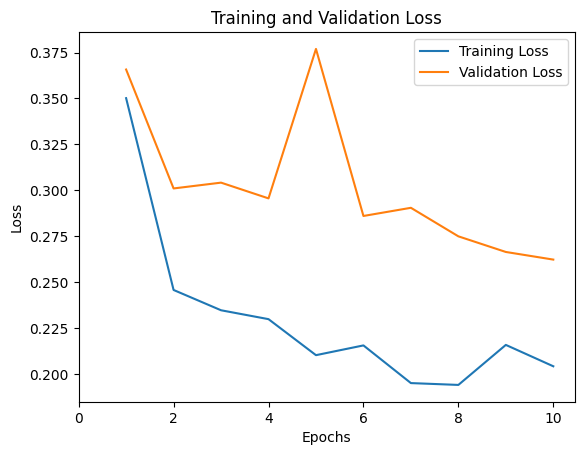

In [33]:
from numpy import *
from pickle import load
# Load the training and validation loss dictionaries
train_loss = load(open('/kaggle/working/train_loss_2d_WBCE.pkl', 'rb'))
val_loss = load(open('/kaggle/working/val_loss_2d_WBCE.pkl', 'rb'))
 
# Retrieve each dictionary's values
train_values = train_loss.values()
val_values = val_loss.values()
 
# Generate a sequence of integers to represent the epoch numbers
epochs_range = range(1, epochs+1)
 
# Plot and label the training and validation loss values
plt.plot(epochs_range, train_values, label='Training Loss')
plt.plot(epochs_range, val_values, label='Validation Loss')
 
# Add in a title and axes labels
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(np.arange(0, epochs+1, 2))
 
# Display the plot
plt.legend(loc='best')
plt.show()

**7) How are the three models (model_1_BCE.pt, model_2d_BCE.pt, and model_2d_WBCE.pt) performning? Comment the performances of the models.**

Our first model, trained on the full dataset with standard BCE loss, outperformed by far the other approaches, achieving an IoU of 0.6119 and F1 score of 0.7592. This model had an excellent balance between precision (0.9225) and recall (0.6451), demonstrating that the original dataset distribution was suitable for training without requiring extensive rebalancing techniques. In contrast, our second model trained on the undersampled dataset with standard BCE loss performed poorly (IoU: 0.0309, F1: 0.0599), showing extreme bias toward precision (0.9767) at the expense of recall (0.0309).

We found that our third model, which combined undersampling with weighted BCE loss, overcompensated for the class imbalance, resulting in bad performance (IoU: 0.1226, F1: 0.2183) with a strong bias toward recall (0.8681) but very low precision (0.1249). These results highlight that class balancing techniques don't always yield better results than simpler approaches. For our specific task, the best performance came from using the full dataset with standard BCE loss, suggesting that modern neural network architectures like UNet with ResNet34 can indeed learn from imbalanced datasets when configured properly. Based on these findings, we selected Model 1 for our final inference stage.

# Step 9a (Optional): Train more models
Feel free to train mode model changing the configuration, learning rate, optimizer, loss function, etc. This is fully optional and bonus points will be assigned to go beyond the max grade. Total freedom here to create #Step 9b, 9c, etc.. Rememebr that this is 100% optional and won't influence your grading, it is a space to experiment ideas. I suggest you finalize the notebook first given the limited computational resources and get back to this later. 

Please add in the text cell below the idea behind the experiment you are about to run. Why do you want to test that specific conifguration? What do you expect in terms of results and what did you get after training? 

In [ ]:
### CREATE A TEXT CELL BELOW AS EXPLAINED ABOVE EXPLAINING YOUR EXPERIMENT

Let's train the second model with transfer learning from Imagenet using imagenet stats

#### Create the dataloader (if needed) and the model (if needed)

In [ ]:
### CODE HERE


### Model config, optimizer and loss function

In [ ]:
###CODE HERE


### Training Loop

In [ ]:
### CODE HERE

### Plot Losses

In [ ]:
### CODE HERE


# Step 10: Test models

### Create a test dataset
Let's create Dataset and DataLoader objects for the validation set. This time we will not have labels.

In [29]:
vv_image_paths = sorted(glob(test_dir+'/**/vv/*.png', recursive=True))
vv_image_names = [get_filename(pth) for pth in vv_image_paths]
region_name_dates = ['_'.join(n.split('_')[:2]) for n in vv_image_names]

vh_image_paths, flood_label_paths, water_body_label_paths, region_names = [], [], [], []
for i in range(len(vv_image_paths)):
    # get vh image path
    vh_image_name = vv_image_names[i].replace('vv', 'vh')
    vh_image_path = os.path.join(test_dir, region_name_dates[i], 'tiles', 'vh', vh_image_name)
    vh_image_paths.append(vh_image_path)

    # get flood mask path ()
    flood_label_paths.append(np.NaN)

    # get water body mask path
    water_body_label_name = vv_image_names[i].replace('_vv', '')
    water_body_label_path = os.path.join(test_dir, region_name_dates[i], 'tiles', 'water_body_label', water_body_label_name)
    water_body_label_paths.append(water_body_label_path)

    # get region name
    region_name = region_name_dates[i].split('_')[0]
    region_names.append(region_name)

test_paths = {'vv_image_path': vv_image_paths,
        'vh_image_path': vh_image_paths,
        'flood_label_path': flood_label_paths,
        'water_body_label_path': water_body_label_paths,
        'region': region_names
}

test_df = pd.DataFrame(valid_paths)

print(test_df.shape)
test_df.head()

(5443, 4)


,vv_image_path,vh_image_path,flood_label_path,water_body_label_path
0,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
1,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
2,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
3,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...
4,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...,/kaggle/input/d/gerardogmezargelles/ecti2021/e...


### Run inference

**8) Choose your best performing model from Steps 6-9 and run inference below:**

In [34]:
# load model
model_test = create_model()

# load the weights from the best performing model (Model 1)
model_test.load_state_dict(torch.load('model_1_BCE.pt'))
model_test.to(device)
model_test.eval()

# run inference on validation dataset
final_predictions = []

with torch.no_grad():  
    for idx in tqdm(range(len(valid_df))):
        #loding image data
        vv_image = cv2.imread(valid_df.iloc[idx]['vv_image_path'], 0) / 255.0
        vh_image = cv2.imread(valid_df.iloc[idx]['vh_image_path'], 0) / 255.0
        
        # convert to RGB-like composite
        rgb_image = s1_to_rgb(vv_image, vh_image)
        
        # ---- Prepare input tensor ----
        # convert the image to a PyTorch tensor 
        input_tensor = torch.from_numpy(rgb_image.transpose((2,0,1))).unsqueeze(0).float().to(device)
        
        # get model prediction
        output = model_test(input_tensor)
        
        # convert probabilities to class indices (0: background, 1: flood)
        prediction = output.argmax(dim=1).cpu().numpy()[0]
        final_predictions.append(prediction)
        
    print(f"Inference completed on {len(final_predictions)} validation images")

/tmp/ipykernel_31/1089607472.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_test.load_state_dict(torch.load('model_1_BCE.pt'))


  0%|          | 0/5443 [00:00<?, ?it/s]

Inference completed on 5443 validation images


### Visualize some results

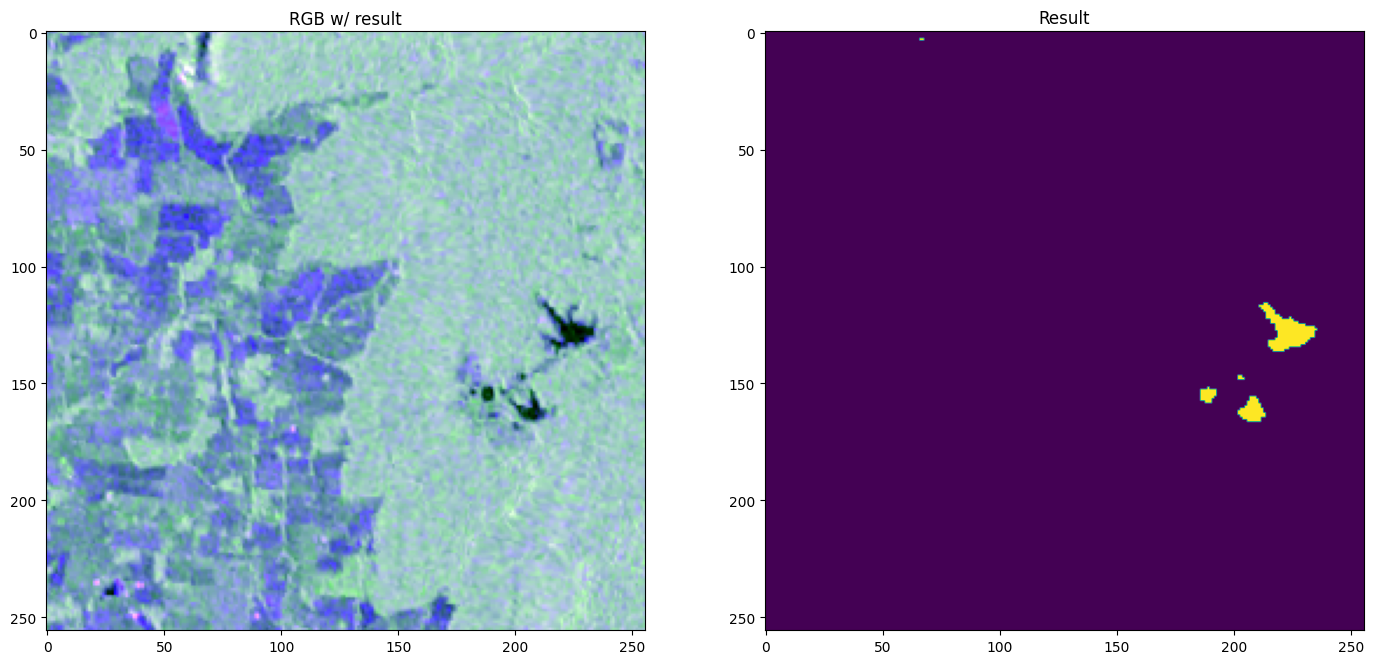

In [39]:
index = 1
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

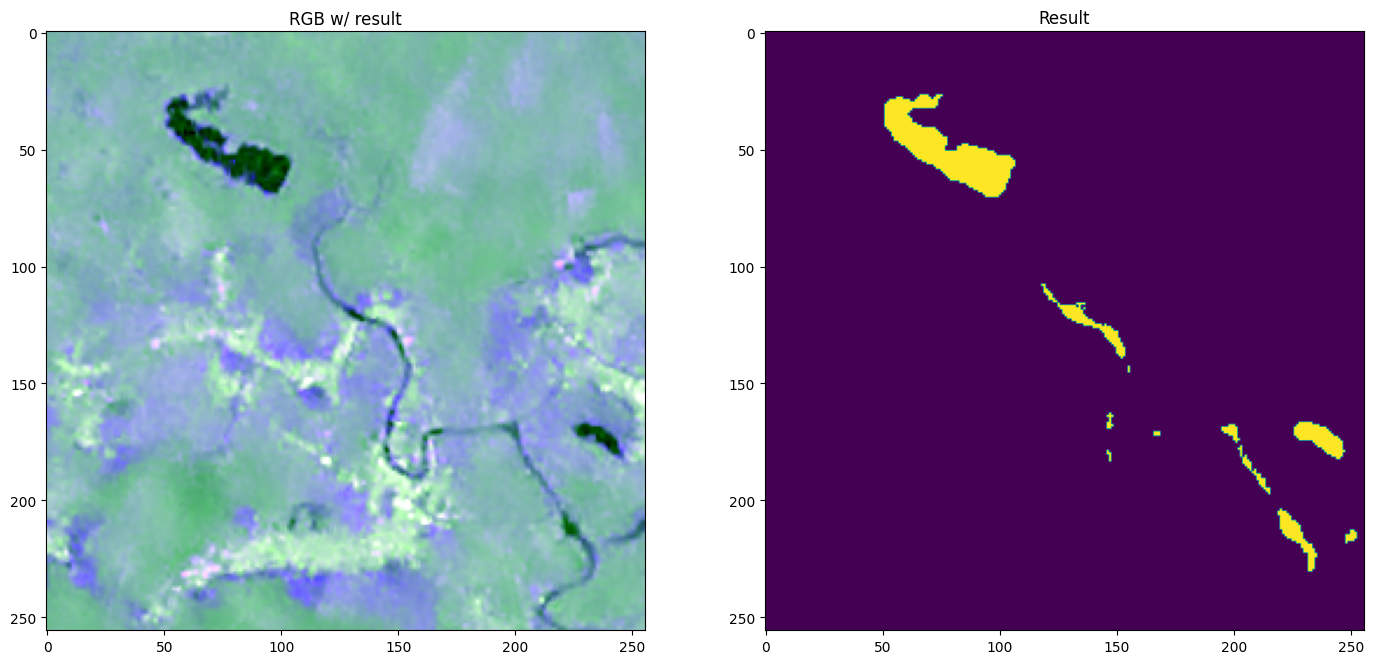

In [36]:
index = -100
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))

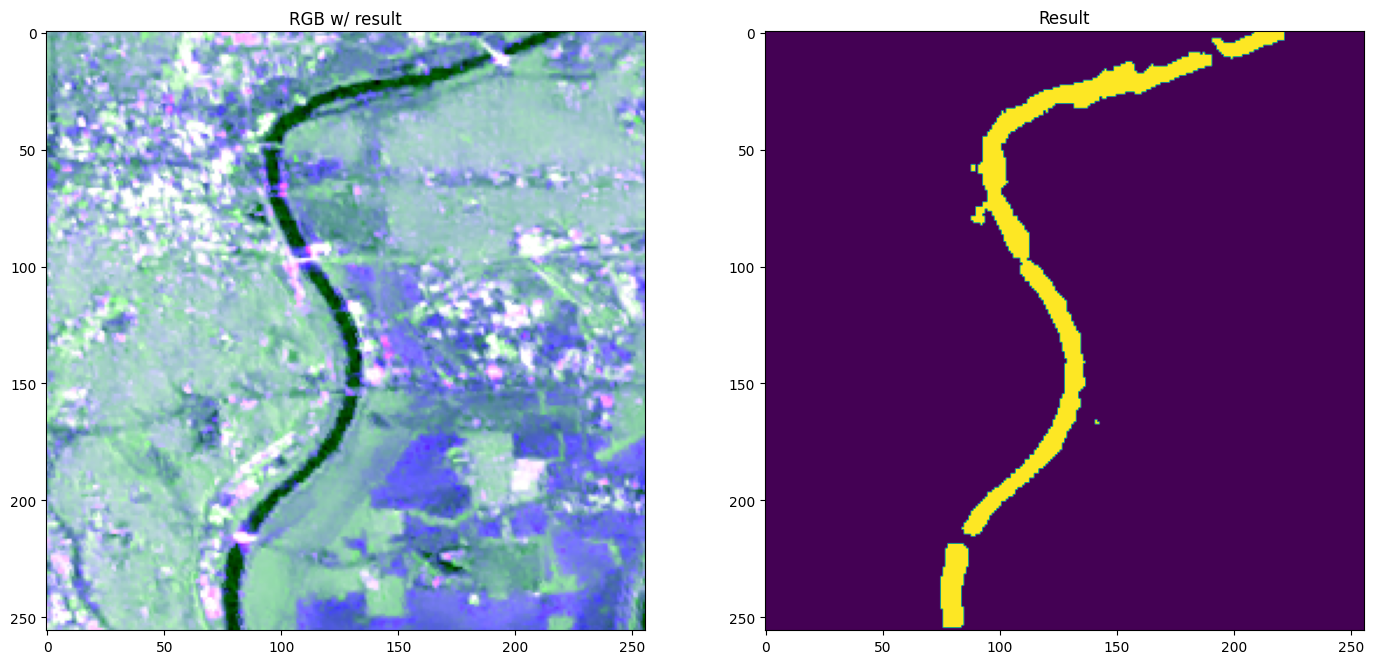

In [43]:
index = 2502
visualize_result(valid_df.iloc[index], final_predictions[index], figsize=(17,10))